## 1.0 Imports

In [2]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import datetime

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats as ss
from IPython import display
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

### 1.1 Helper Functions

In [3]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency (cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1) / (n-1))
    
    kcorr = k - (k-1)**2 / (n-1)
    rcorr = r - (r-1)**2 / (n-1)
    
    return np.sqrt((chi2corr/n) / (min (kcorr-1, rcorr-1) ))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams ['figure.figsize'] = [25,12]
    plt.rcParams ['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

### 1.2 Loading Data

In [4]:
df_sales_raw = pd.read_csv ("data/train.csv", low_memory = False)
df_store_raw = pd.read_csv ("data/store.csv", low_memory = False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [5]:
df_raw.head(15)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN


## 2.0 Descrição dos Dados

In [6]:
df1 = df_raw.copy()

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

### 2.1 Rename Columns

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename

df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 2.2 Data Dimensions

In [10]:
print('Number of rows: {} '.format(df1.shape[0]))
print('Number of columns: {} '.format(df1.shape[1]))

Number of rows: 1017209 
Number of columns: 18 


### 2.3 Data Types

In [11]:
df1 ['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 2.4 Check Na's

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 2.5 Fillout NA

In [13]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month  
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis =1)

#promo_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

# promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)

#promo_interval
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
             
df1['promo_interval'].fillna(0, inplace = True)
             
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split (',') else 0, axis = 1)             
                

In [14]:
df1.head(15)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul,0
5,6,5,2015-07-31,5651,589,1,1,0,1,a,a,310.0,12.0,2013.0,0,31.0,2015.0,0,Jul,0
6,7,5,2015-07-31,15344,1414,1,1,0,1,a,c,24000.0,4.0,2013.0,0,31.0,2015.0,0,Jul,0
7,8,5,2015-07-31,8492,833,1,1,0,1,a,a,7520.0,10.0,2014.0,0,31.0,2015.0,0,Jul,0
8,9,5,2015-07-31,8565,687,1,1,0,1,a,c,2030.0,8.0,2000.0,0,31.0,2015.0,0,Jul,0
9,10,5,2015-07-31,7185,681,1,1,0,1,a,a,3160.0,9.0,2009.0,0,31.0,2015.0,0,Jul,0


In [15]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

### 2.7 Change Data Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )


### 2.8 Estatistic Descriptive

#### 2.8.1 Numerical Attributes

In [18]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

#### 2.8.2 Category Attributes

In [19]:
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'] )

#### 2.8.3 Central Tendency and Dispersion

In [20]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

In [21]:
# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


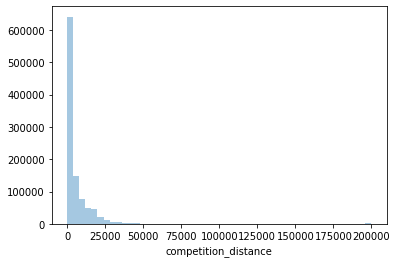

In [22]:
sns.distplot( df1['competition_distance'], kde=False )

#### 2.8.4 Categorycal Attributes Analysis

In [23]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

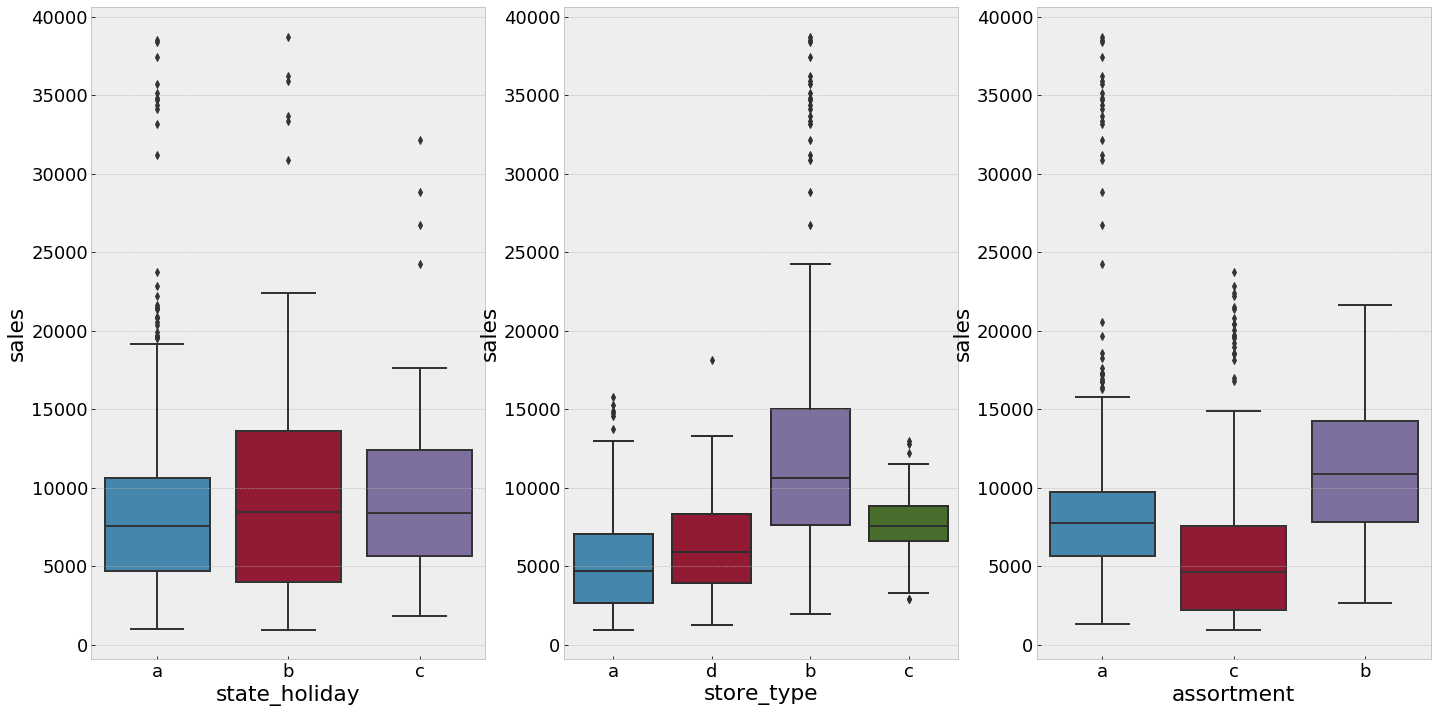

In [25]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
plt.style.use( 'bmh' )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.rcParams['figure.figsize'] = [24,12]
plt.rcParams['font.size'] = 18

plt.subplot( 1, 3, 2 )
plt.style.use( 'bmh' )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.rcParams['figure.figsize'] = [24,12]
plt.rcParams['font.size'] = 18

plt.subplot( 1, 3, 3 )
plt.style.use( 'bmh' )
sns.boxplot( x='assortment', y='sales', data=aux )
plt.rcParams['figure.figsize'] = [24,12]
plt.rcParams['font.size'] = 18



## 3.0 Feature Engineering

In [26]:
df2 = df1.copy()

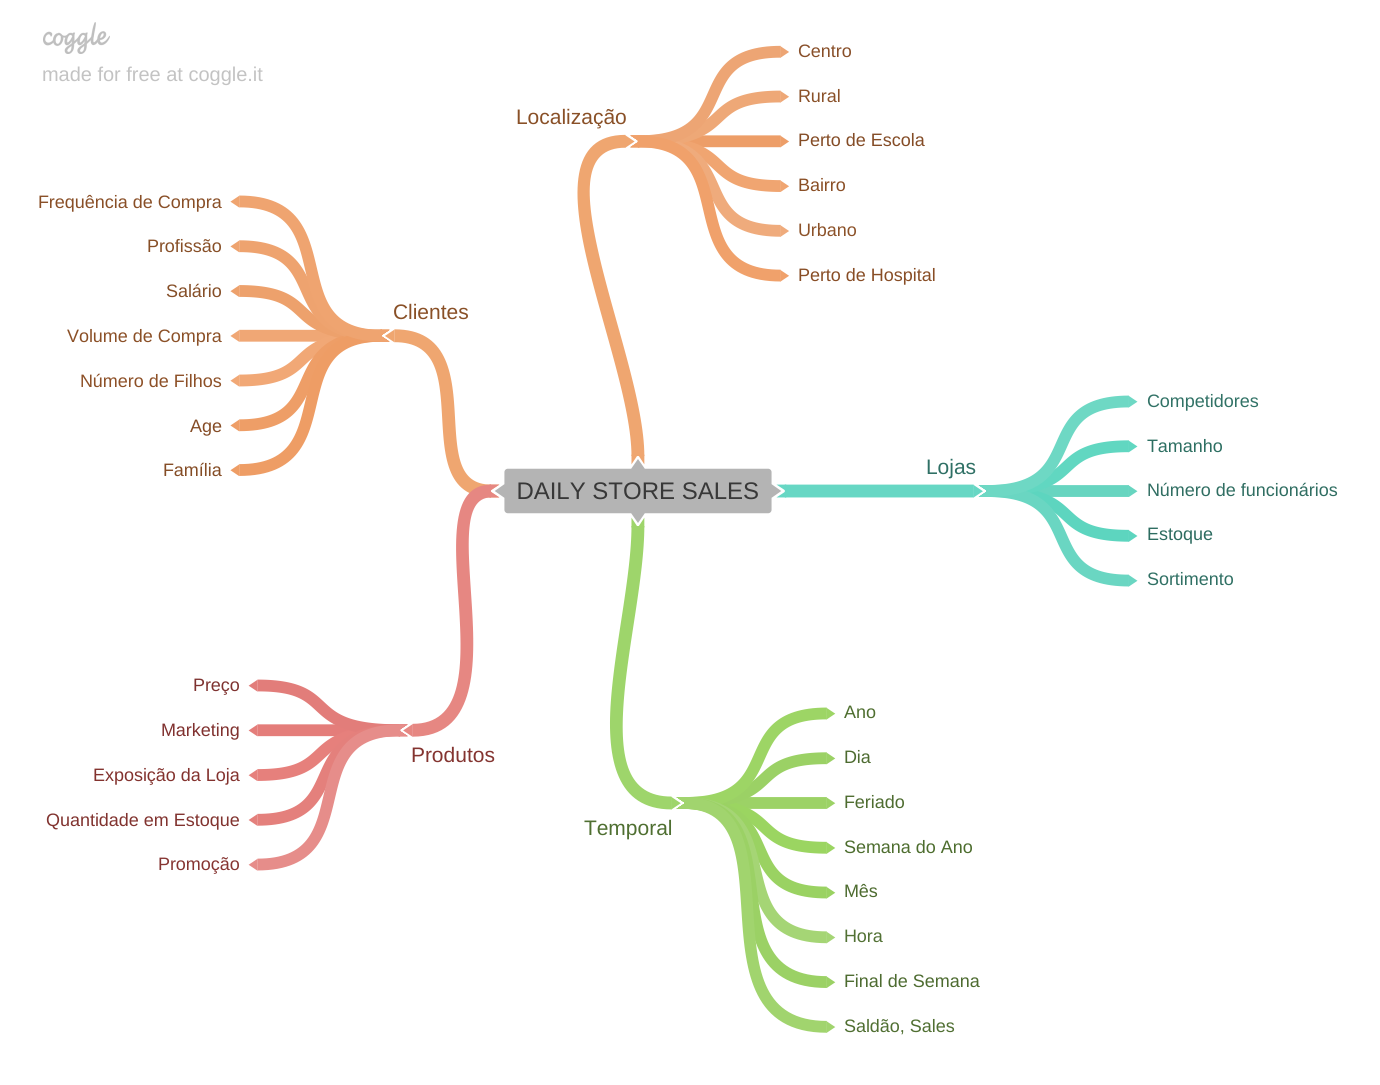

In [27]:
Image('img/Mindmaphypotesis.png')

### 3.1 Criação das Hipóteses

#### 3.1.1 Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

#### 3.1.2 Hipóteses do Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** . Lojas com mais promoções consecutivas deveriam vender mais.

#### 3.1.3 Hipóteses do Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 3.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

### 3.2 Feature Engineering

In [28]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# Competition Since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)


# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7 ).apply(lambda x: x.days).astype(int)


# Assortment a=basic b=extra c= extended
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

# State Holiday a=public holiday b=easter holiday c=Christmas
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')



In [29]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 4.0 Filtragem de Variáveis

In [30]:
df3 = df2.copy()

In [31]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### 4.1 Filtragem das Linhas

In [32]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

### 4.2 Seleção das Colunas

In [33]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

## 5.0 Análise Exploratória dos Dados

In [34]:
df4 = df3.copy()

### 5.1 Análise Univariada

#### 5.1.1 Response Variable

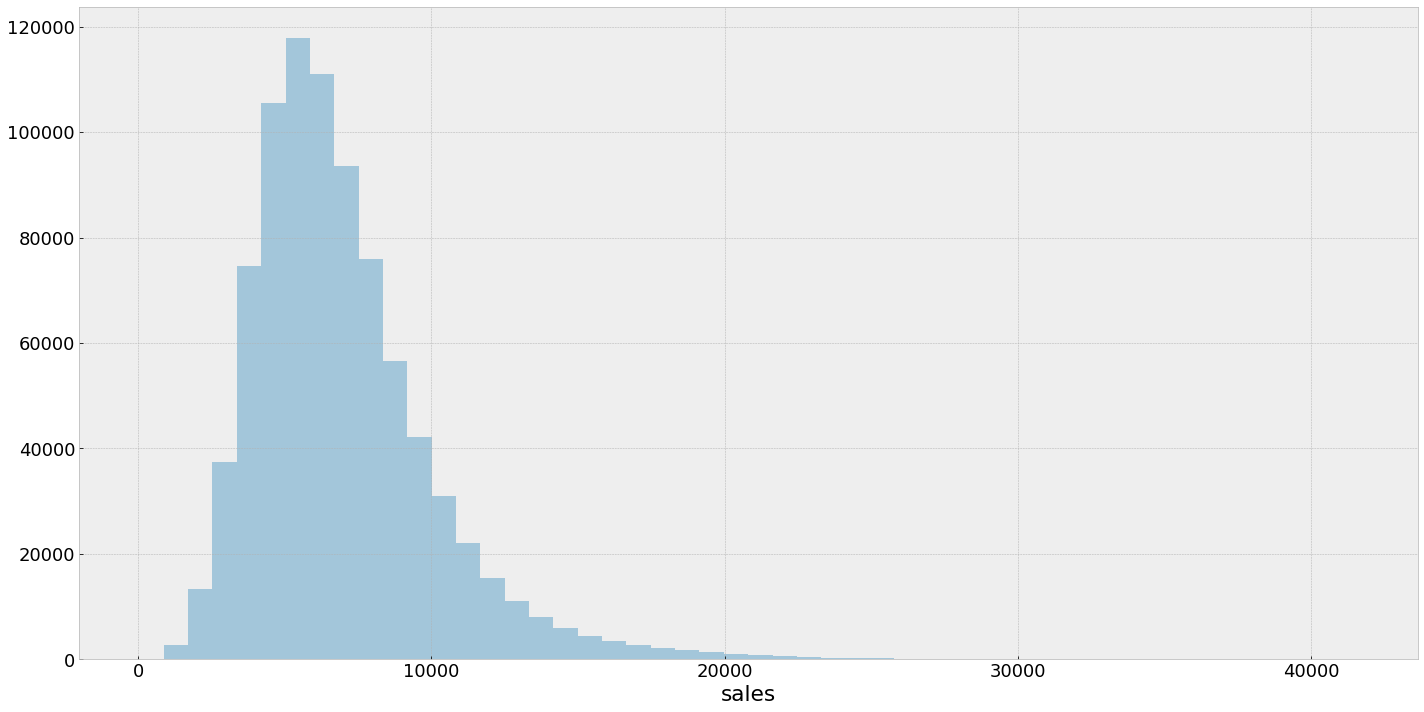

In [38]:
sns.distplot(df4['sales'], kde = False)

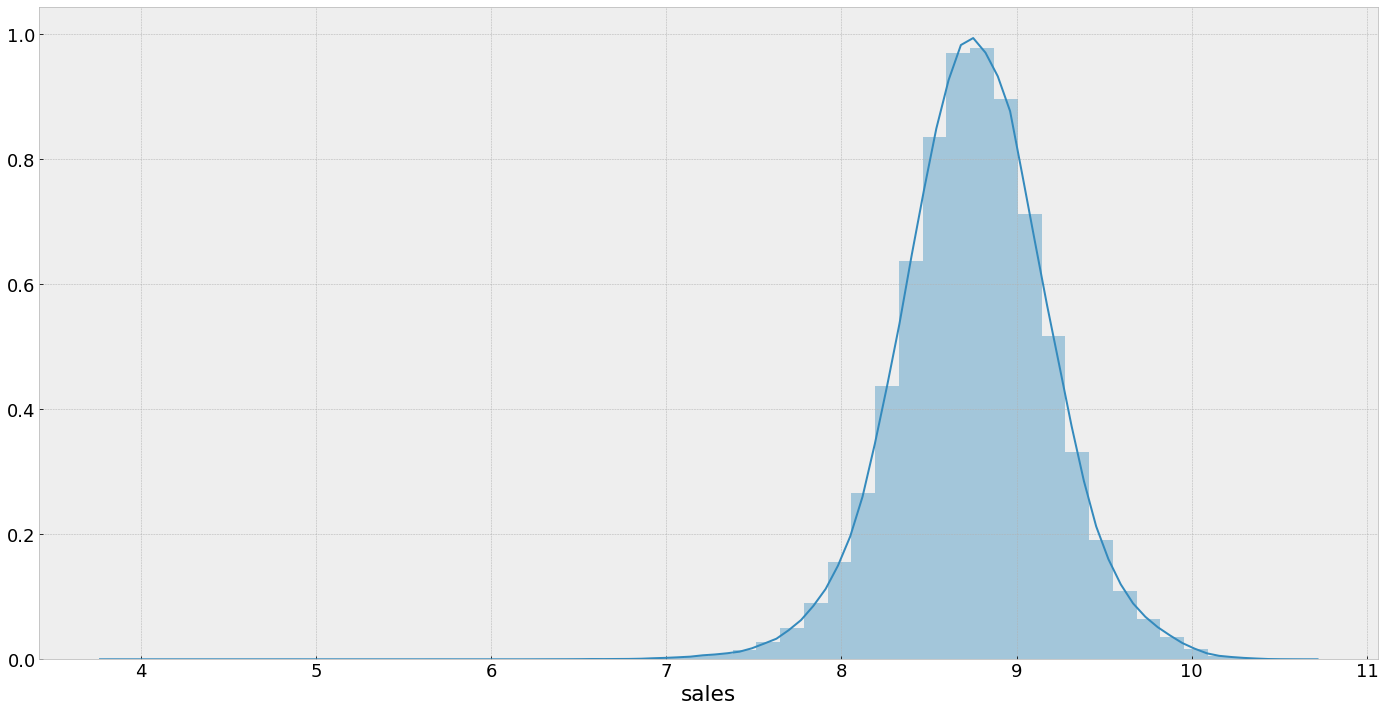

In [39]:
sns.distplot(np.log1p(df4['sales']))

#### 5.1.2 Numerical Variable

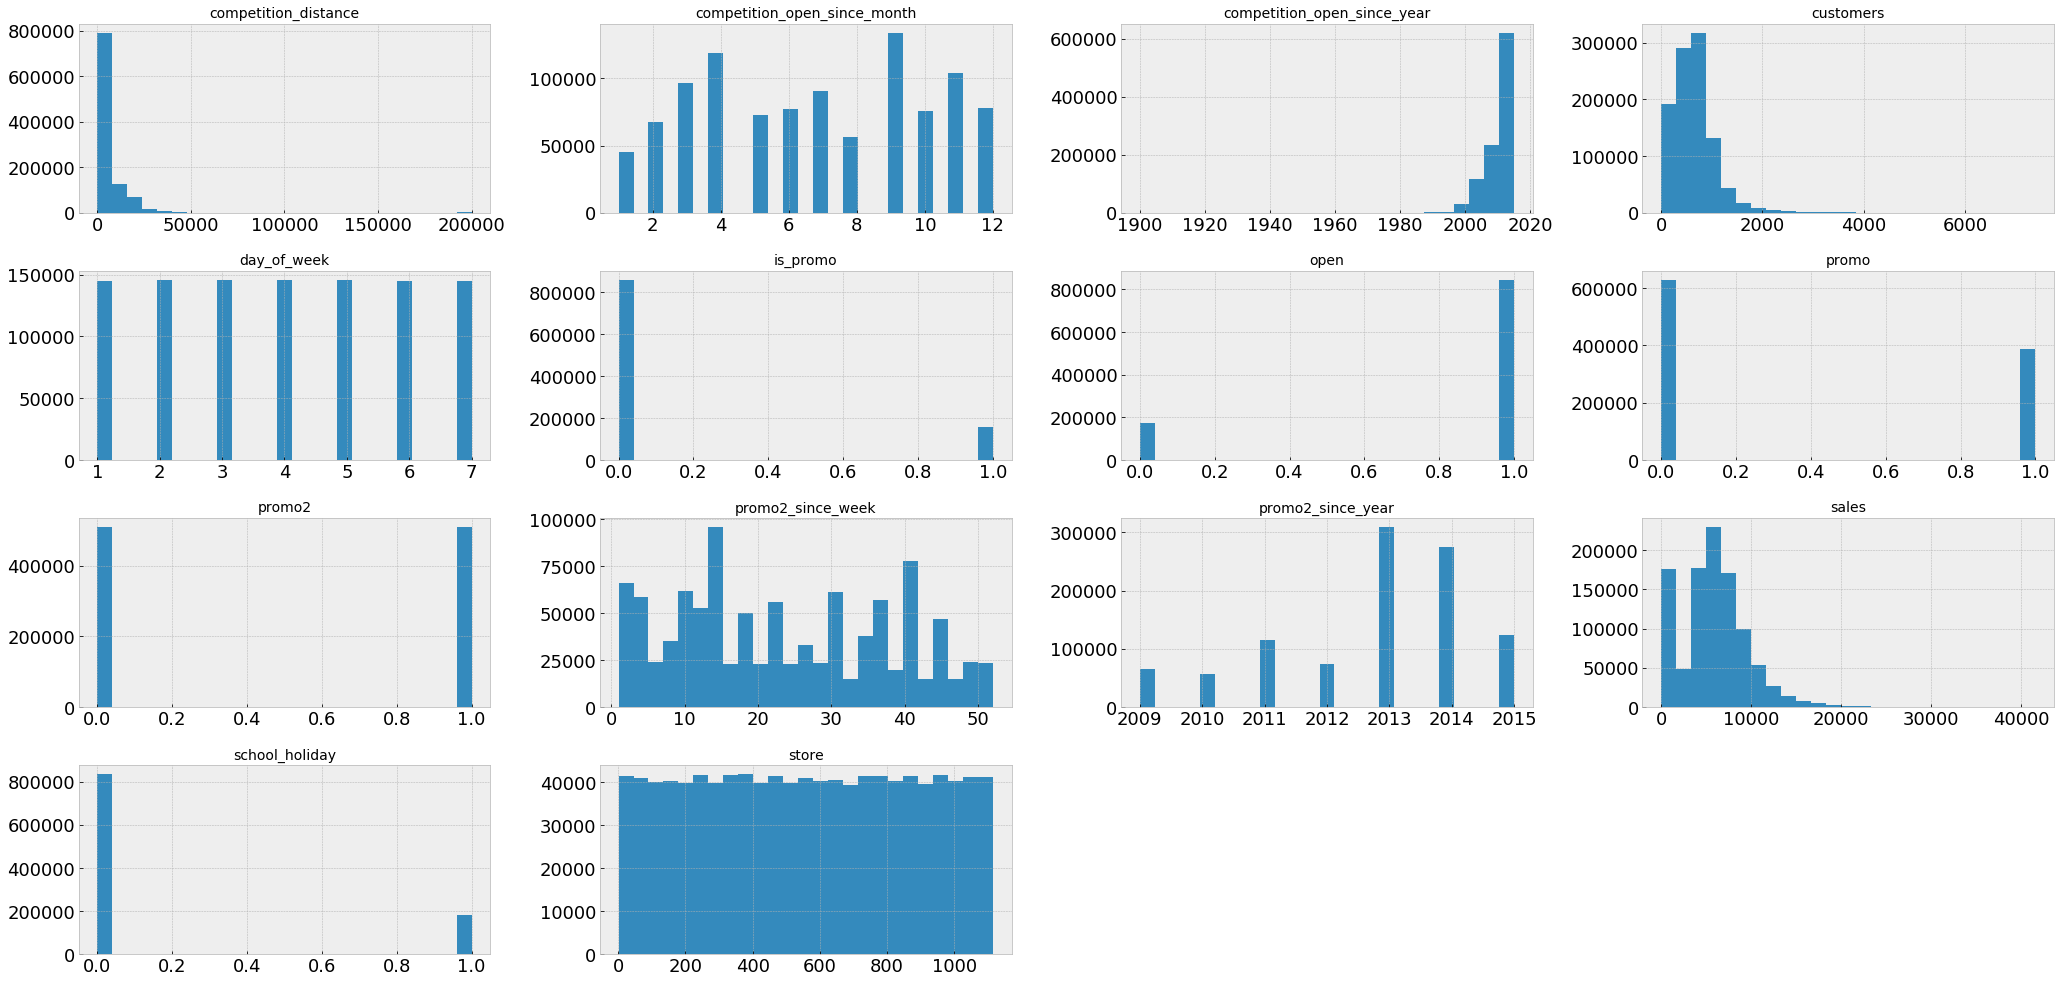

In [40]:
#num_attributes.hist()

axes = num_attributes.hist(bins = 25, figsize=(29,14));
axes

for ax in axes.flatten():
    ax.set_title(ax.get_title(), fontsize=14)  # Ajuste o tamanho da fonte do título do histograma

    
# Ajuste o layout da figura para evitar sobreposição de subplots
plt.tight_layout()

# Mostre os histogramas
plt.show()

#### 5.1.3 Categorical Variable

In [41]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [42]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

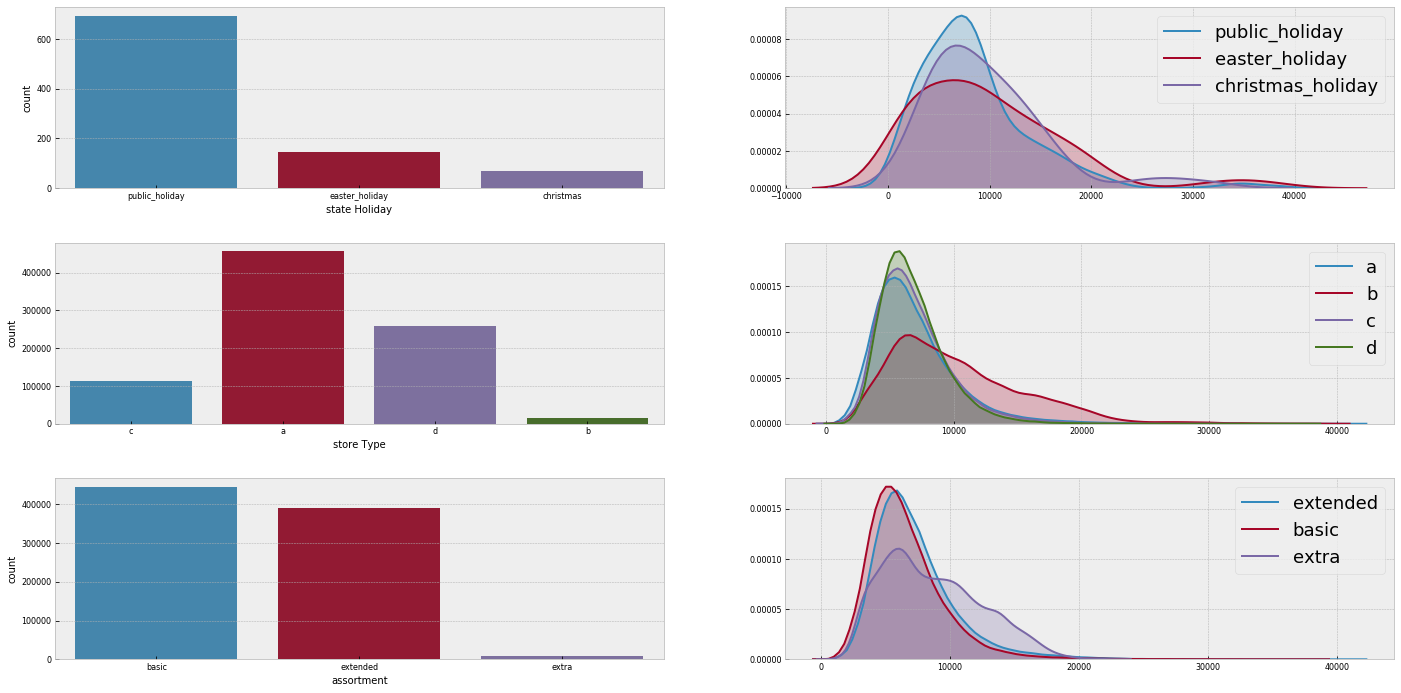

In [43]:
# State Holiday

plt.subplot (3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])
plt.ylabel('count', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo Y
plt.xlabel('state Holiday', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo X
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y

plt.subplot (3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas_holiday', shade = True)
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y

# Store Types

plt.subplot (3, 2, 3)
sns.countplot(df4['store_type'])
plt.ylabel('count', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo Y
plt.xlabel('store Type', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo X
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y

plt.subplot (3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade = True)
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y


# Assortment
plt.subplot (3, 2, 5)
sns.countplot(df4['assortment'])
plt.ylabel('count', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo Y
plt.xlabel('assortment', fontsize=10)  # Diminuindo o tamanho da fonte do rótulo X
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y


plt.subplot (3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade = True)
plt.xticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8)  # Diminuir o tamanho da fonte dos pontos no eixo y

plt.subplots_adjust(hspace=0.3, wspace=0.2)


### 5.2 Análise Bivariada

#### **H1.** Lojas com maior sortimentos deveriam vender mais.
**Falsa** Lojas com MAIOR SORTIMENTO vendem MENOS

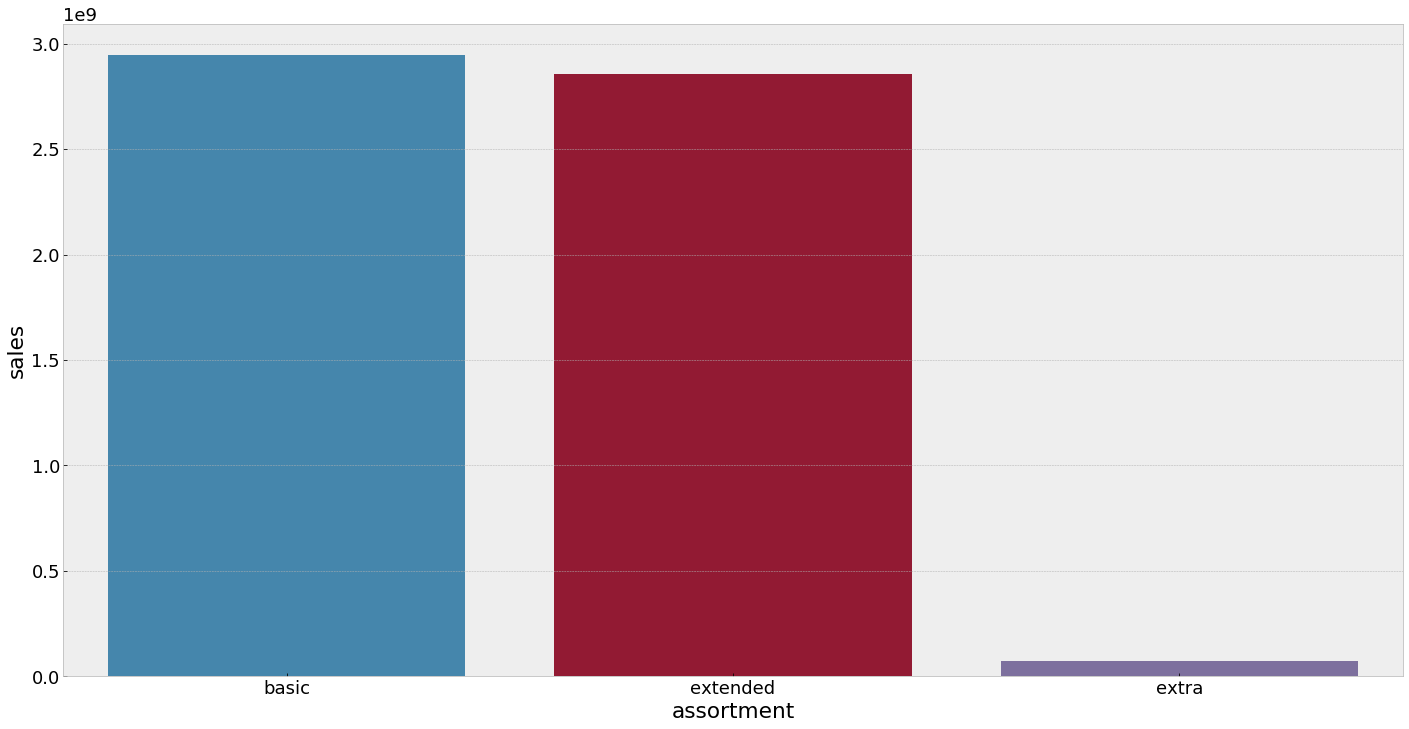

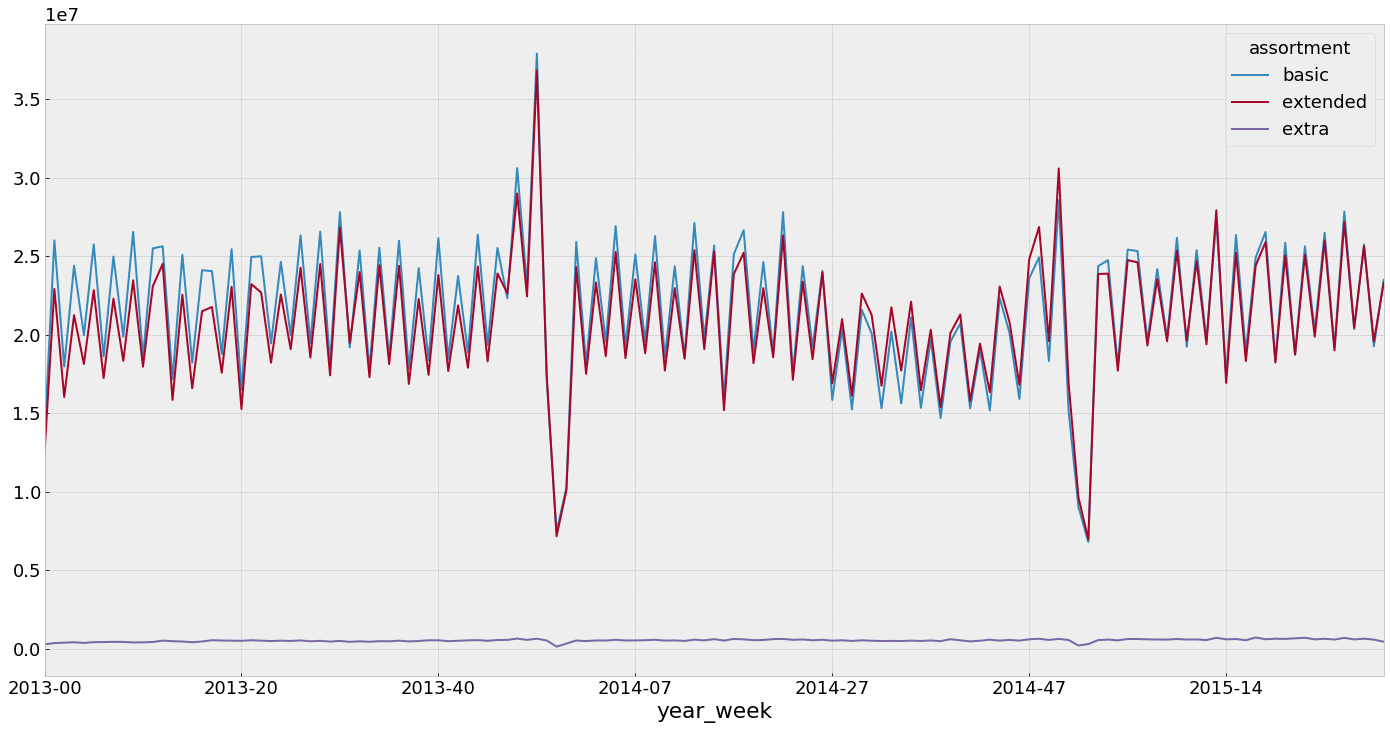

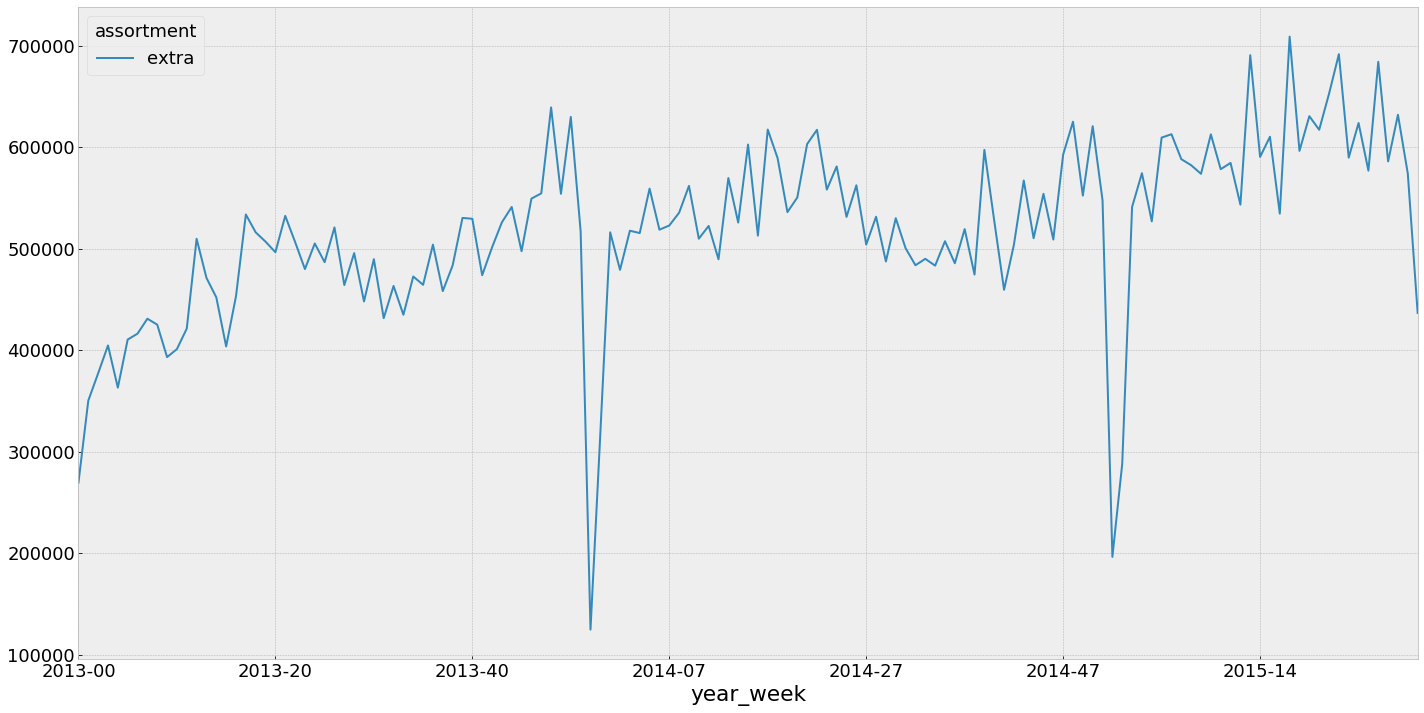

In [44]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales',data=aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

#### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**Falsa** Lojas com COMPETIDORES MAIS PRÓXIMOS vendem MAIS

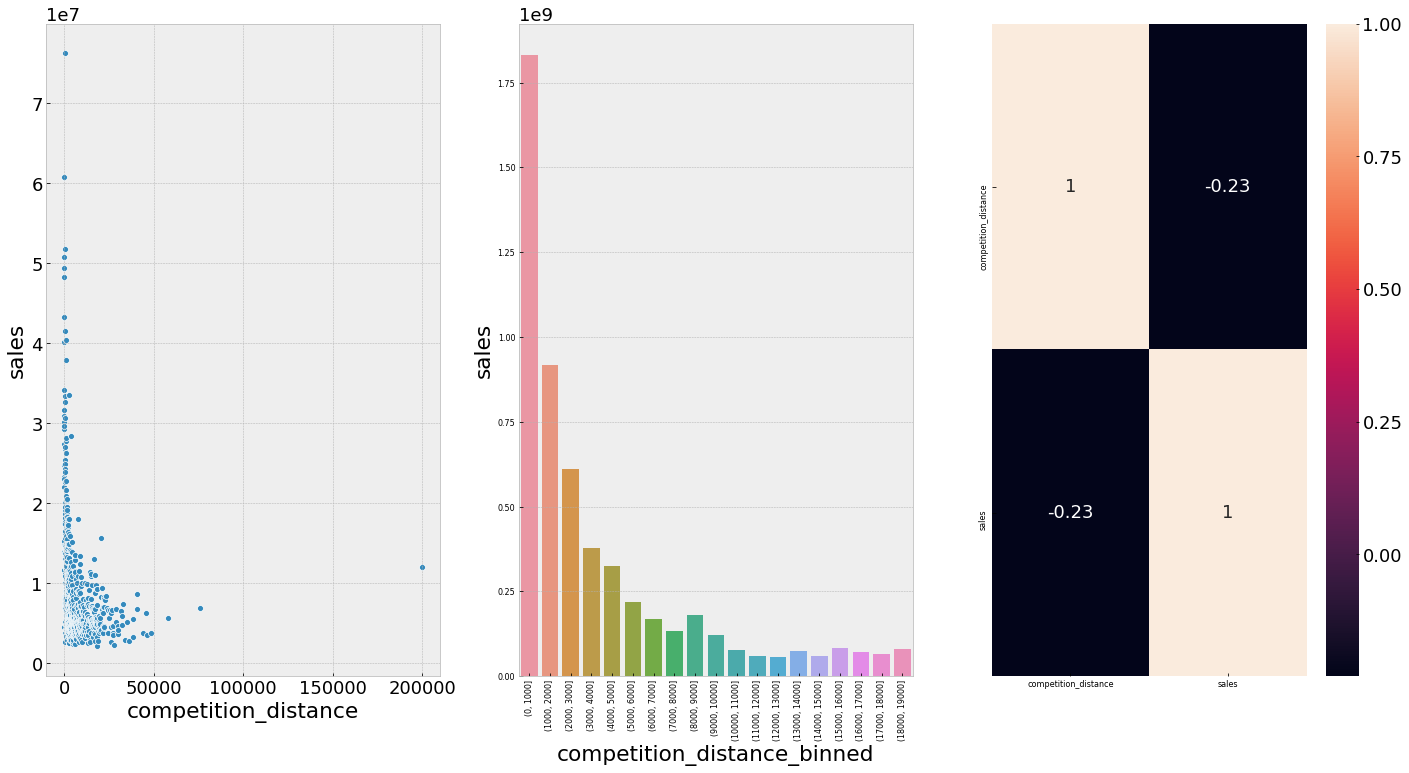

In [45]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(fontsize=8);  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo y
plt.xticks(rotation = 90)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);
plt.xticks(fontsize=8);  # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo y


#### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**Falsa** Lojas com competidores A MAIS TEMPO vendem MENOS

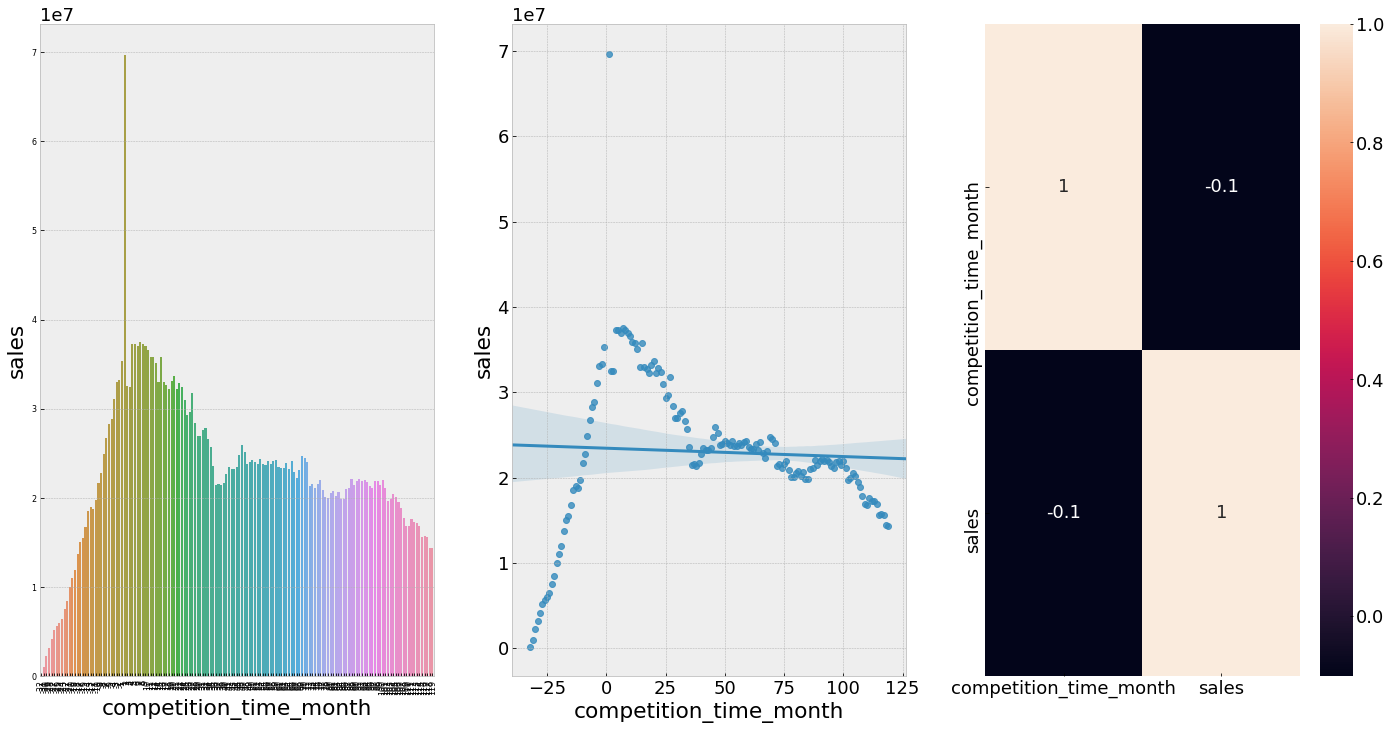

In [46]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo y
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot= True);

#### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção


In [47]:
df4.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
assortment,basic,basic,basic,extended,basic
competition_distance,1270,570,14130,620,29910


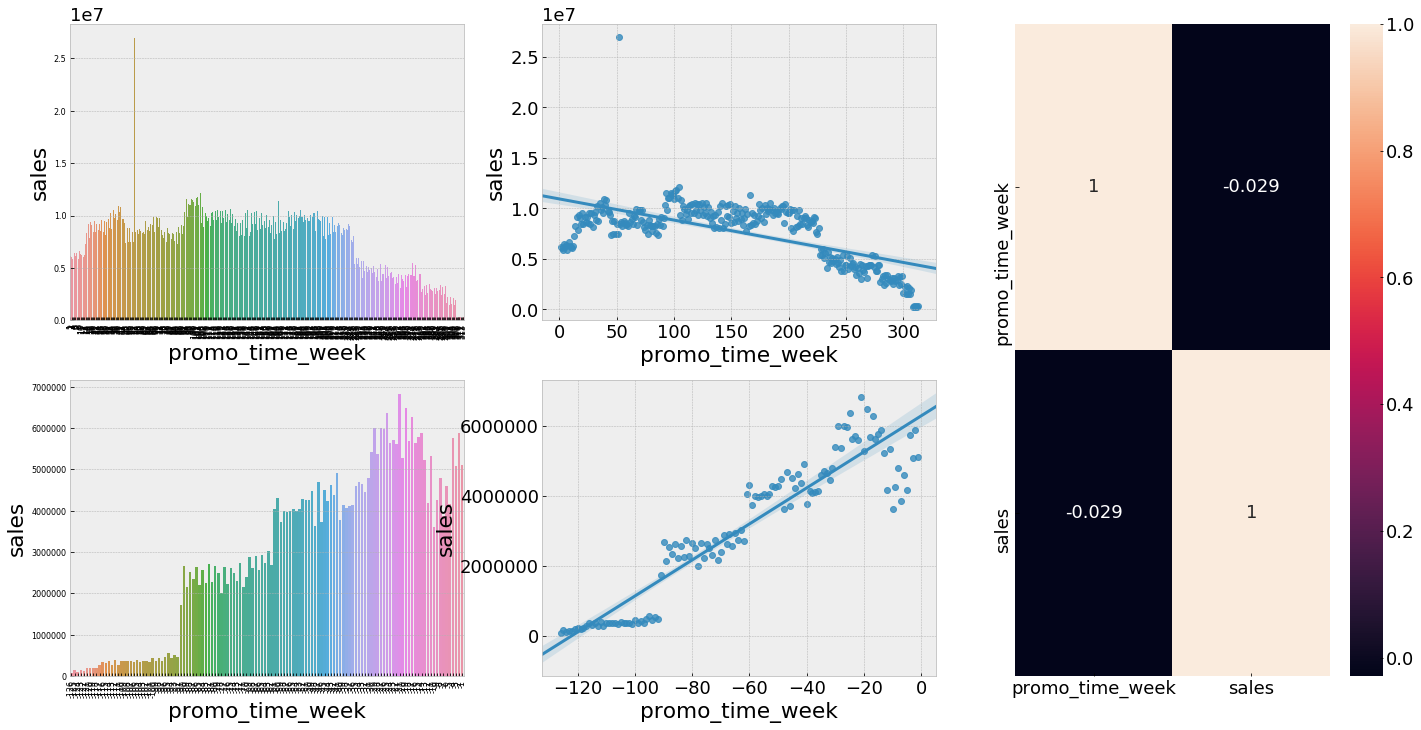

In [48]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot (grid [0, 0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendida
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo y
plt.xticks(rotation = 90)

plt.subplot (grid [0, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot (grid [1, 0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo x
plt.yticks(fontsize=8); # Diminuir o tamanho da fonte dos pontos no eixo y
plt.xticks(rotation = 90);

plt.subplot(grid [1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid [:,2])
sns.heatmap(aux1.corr(method = 'pearson'), annot = True)

#### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais</s>

#### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**Falsa** Lojas com mais promoções consecutivas, vendem menos

In [49]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


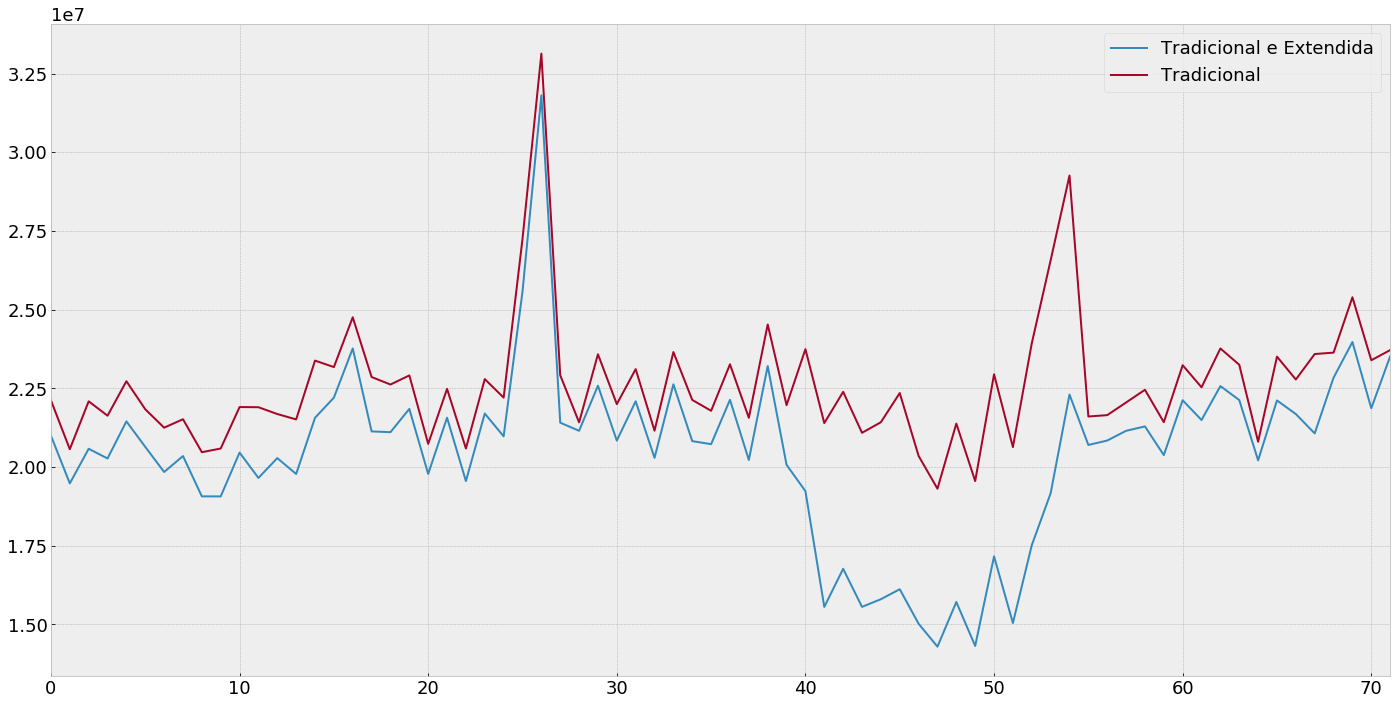

In [50]:
aux1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Tradicional e Extendida', 'Tradicional'] );

#### **H7**. Lojas abertas durante o feriado de Natal deveriam vender mais.
**Falsa** Lojas abertas durante o feriado do Natal vendem MENOS


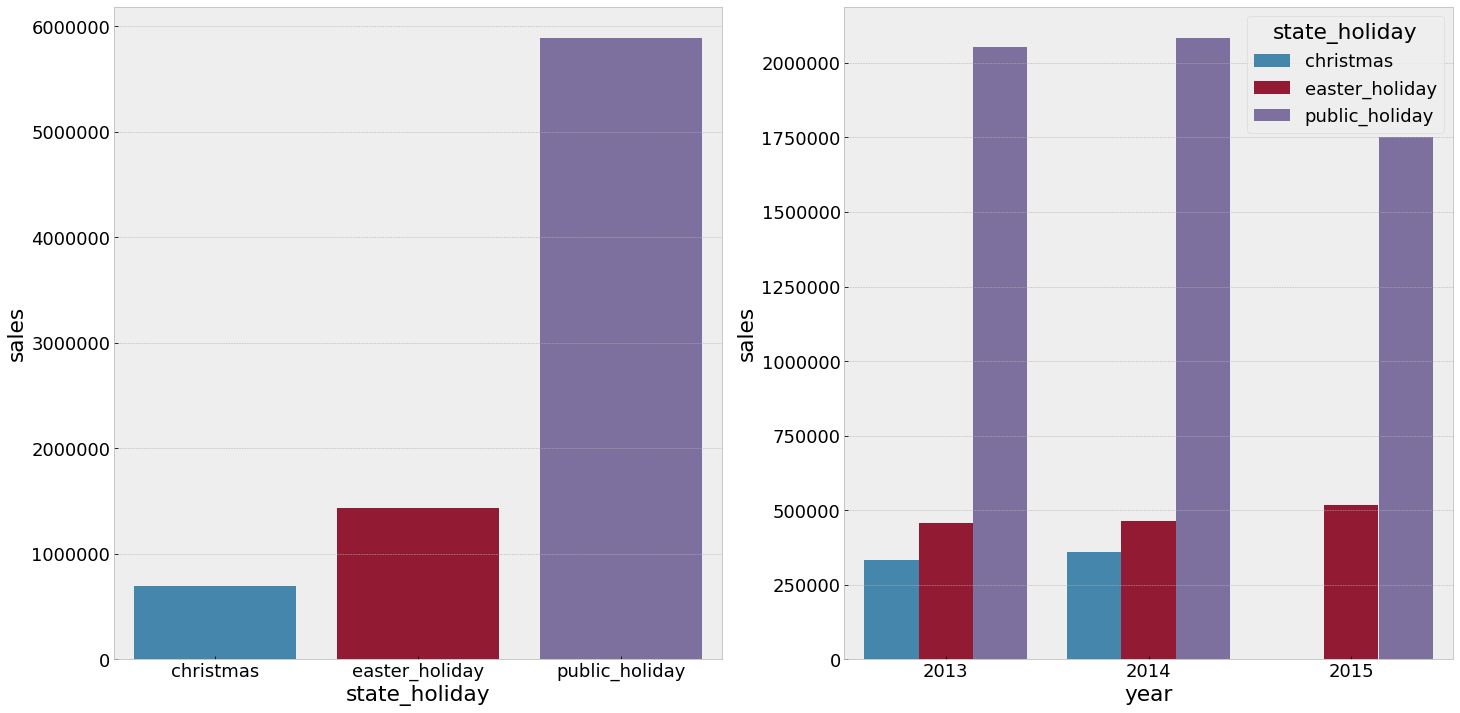

In [51]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot (1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

#aux1 = df4[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
#aux2 = aux1[(aux1['state_holiday'] != 'regular_day')]
#sns.barplot(x='state_holiday', y='sales', data=aux2)

#### **H8**. Lojas deveriam vender mais ao longo dos anos.
**Falsa** Lojas vendem MENOS ao longo dos anos


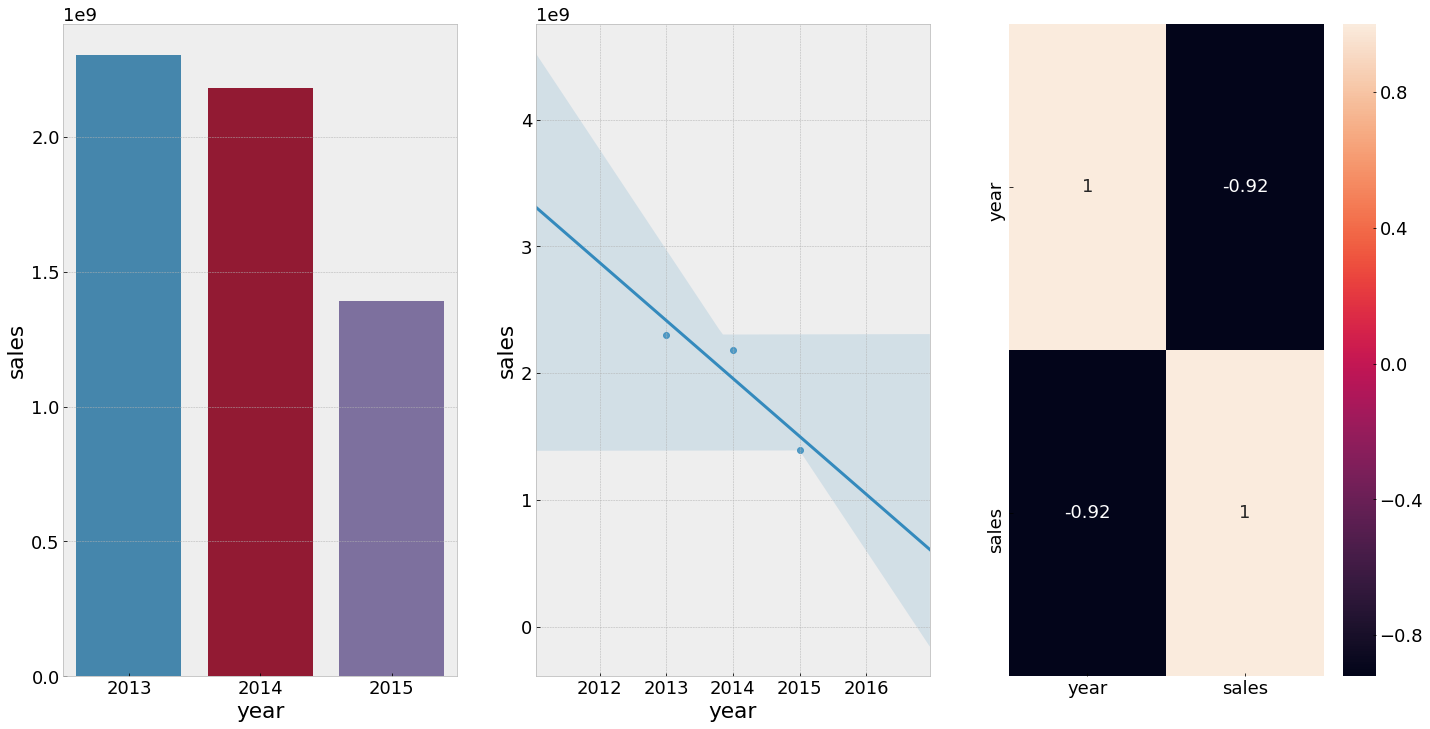

In [52]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux1); # Calcular a tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); # Avaliar força de correlação da variável

#### **H9**. Lojas deveriam vender mais no segundo semestre do ano.
**Falsa** No segundo semestre de TODOS os anos as lojas vendem MENOS


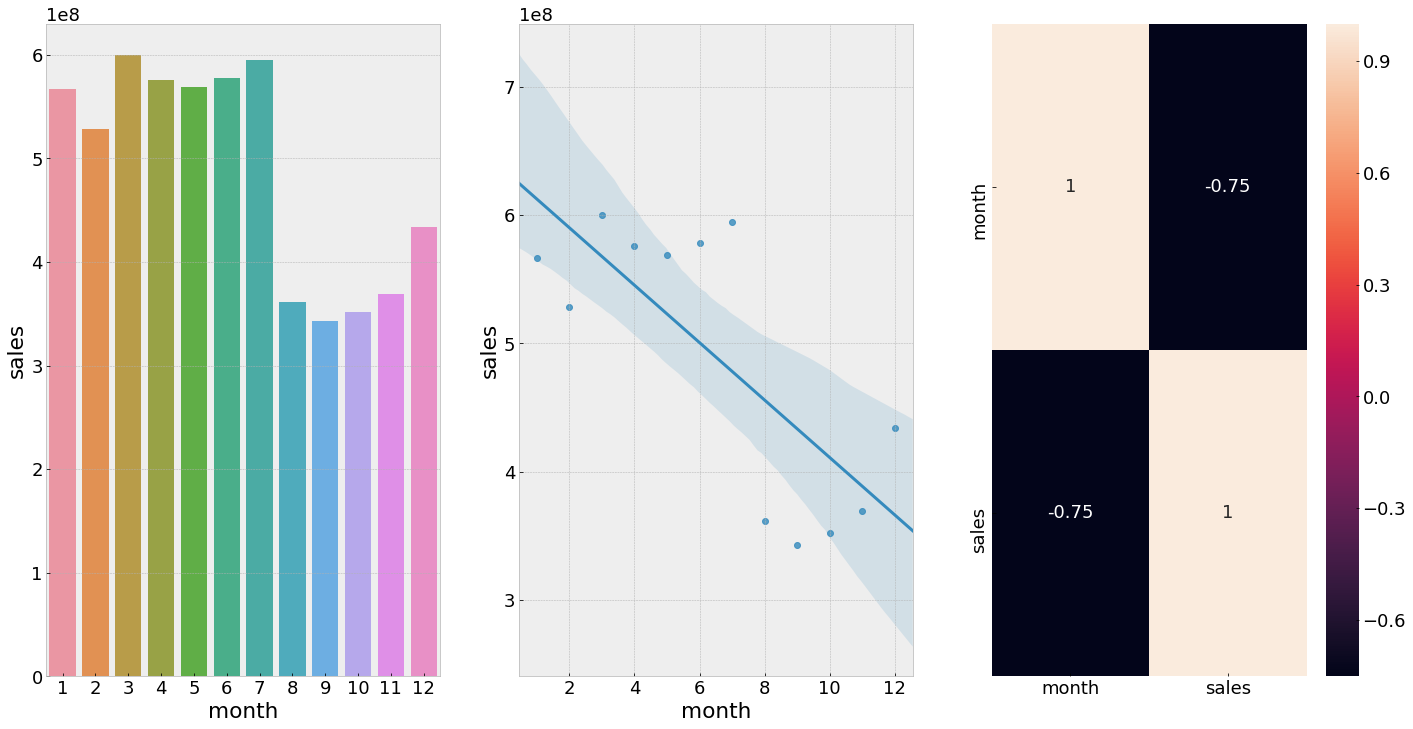

In [53]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1); # Calcular a tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); # Avaliar força de correlação da variável

#### **H10**. Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdade** Lojas vendem MAIS depois do dia 10 de cada mês


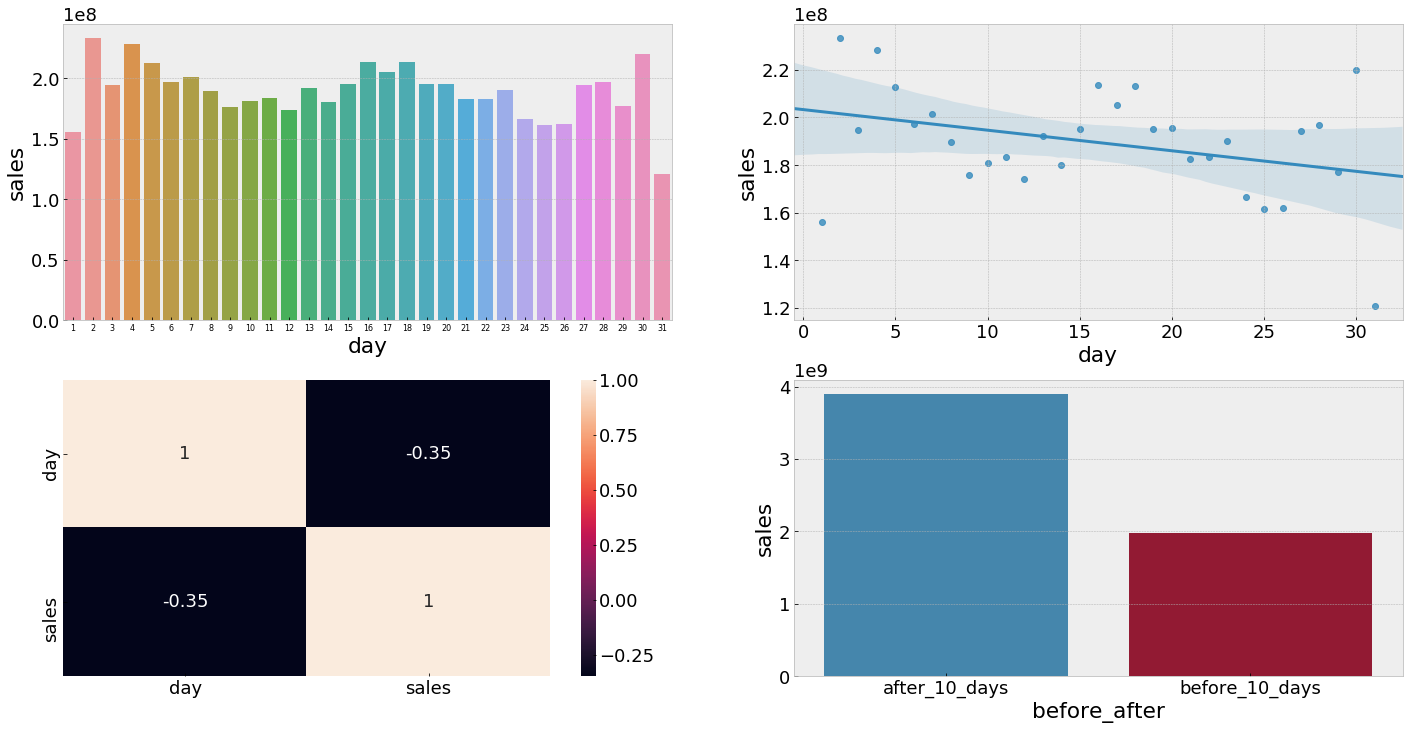

In [54]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);
plt.xticks(fontsize=8);


plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux1); # Calcular a tendencia

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); # Avaliar força de correlação da variável

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

plt.subplot(2,2,4)
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux2);

#### **H11**. Lojas deveriam vender menos aos finais de semana.
**Verdade** Lojas vendem MENOS em finais de semana


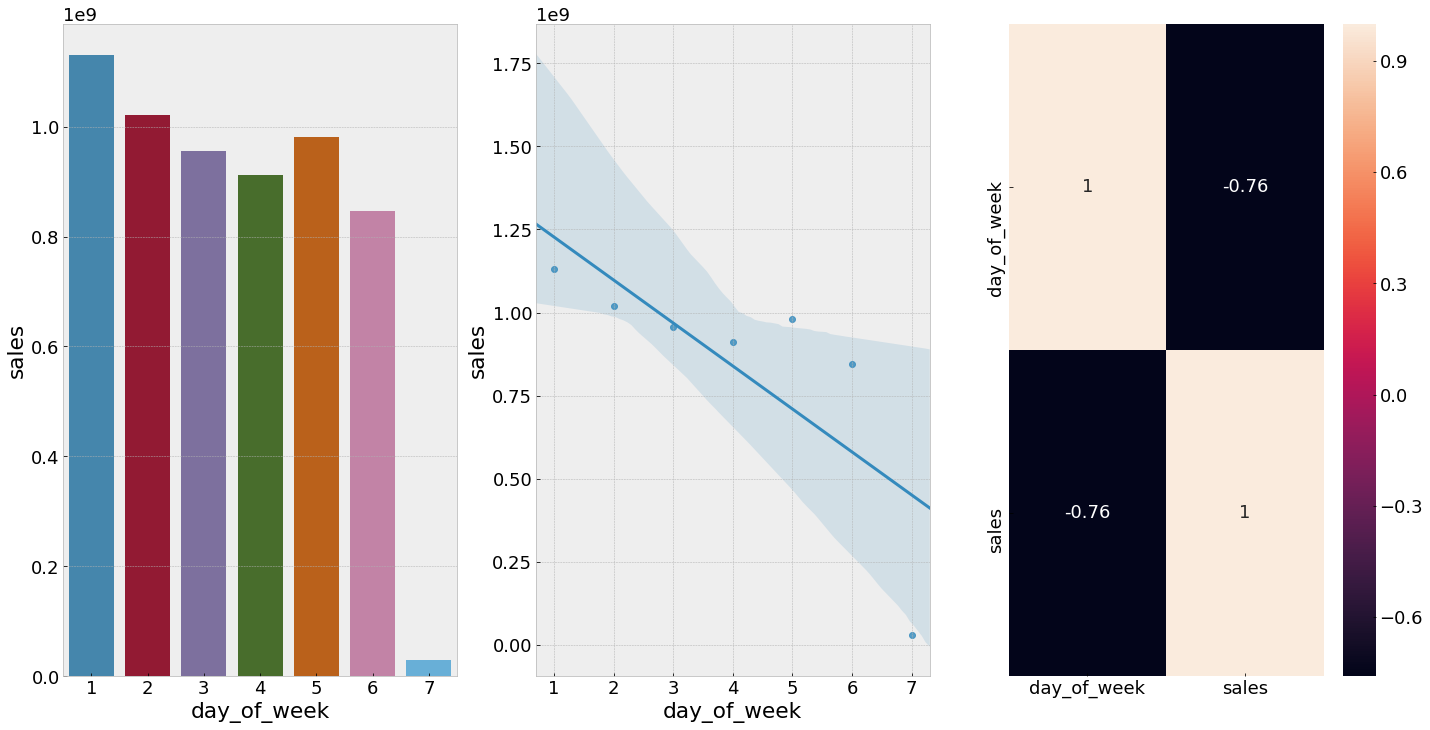

In [55]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux1); # Calcular a tendencia

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True); # Avaliar força de correlação da variável

#### **H12**. Lojas deveriam vender menos durante os feriados escolares
**Verdade** Lojas vendem Menos durante feriados escolares EXCETO nos meses de JULHO e Agosto

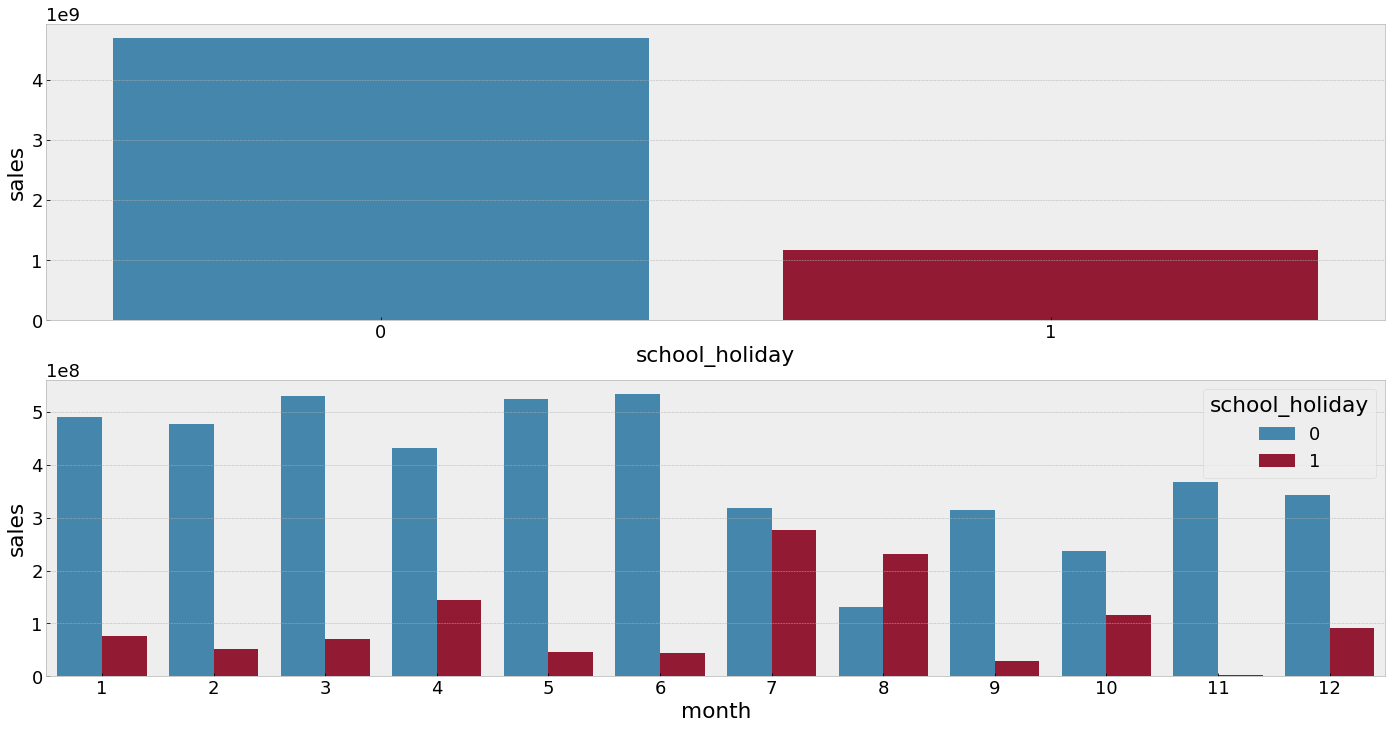

In [56]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday', y='sales', data=aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

#### 5.2.1 Resumo das Hipóteses

In [57]:
from tabulate import tabulate

In [58]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],
      ['H2', 'Falsa', 'Media'],
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'ALta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]
print (tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   ALta
H12          Verdadeira   Baixa


### 5.3 Análise Multivariada

#### 5.3.1 Numerical Attributes

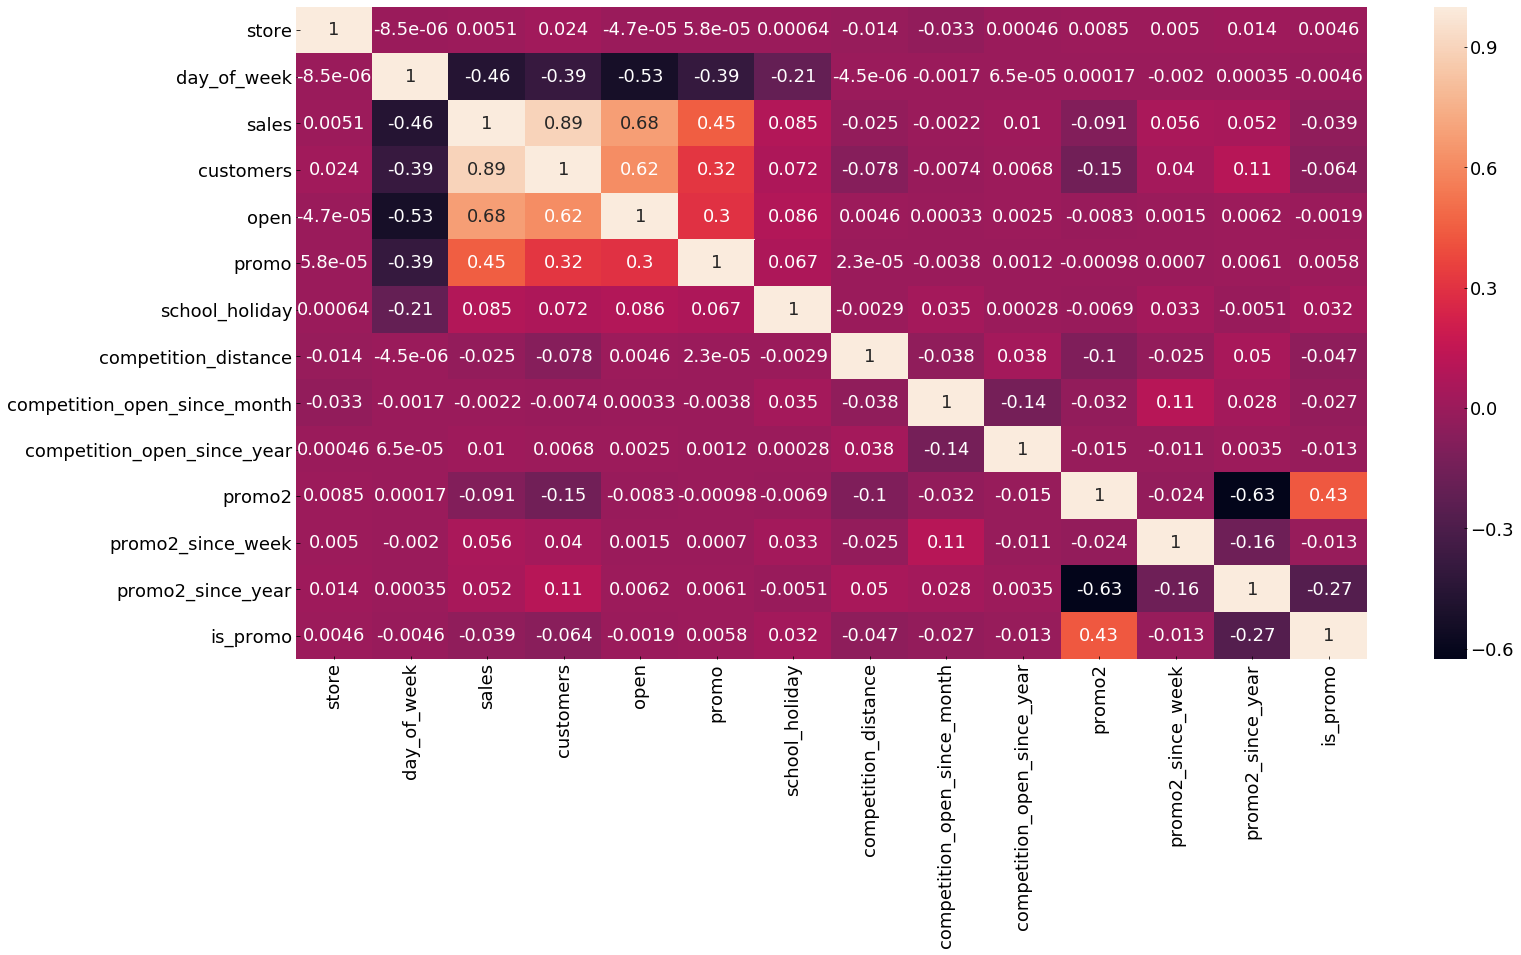

In [59]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

#### 5.3.2 Categorical Attributes

In [60]:
a = df4.select_dtypes(include='object')

In [61]:
a.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [62]:
cm = pd.crosstab(a['state_holiday'], a['store_type']).as_matrix()

<ipython-input-62-77a735511d90>:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(a['state_holiday'], a['store_type']).as_matrix()


In [63]:
chi2 = ss.chi2_contingency (cm)[0]

n = cm.sum()

r, k = cm.shape

In [64]:
v = np.sqrt((chi2/n) / (min (k-1, r-1) ))

In [65]:
v

0.07106457093267678

In [66]:
a[(a['state_holiday'] == 'christmas') & (a['store_type'] == 'a')]

,state_holiday,store_type,assortment,year_week
241499,christmas,a,extended,2014-51
241977,christmas,a,extended,2014-51
616339,christmas,a,extended,2013-51
616908,christmas,a,extended,2013-51


In [67]:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame ({'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]})
d = d.set_index(d.columns)
d

<ipython-input-3-4008a96a0f73>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x, y).as_matrix()


,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


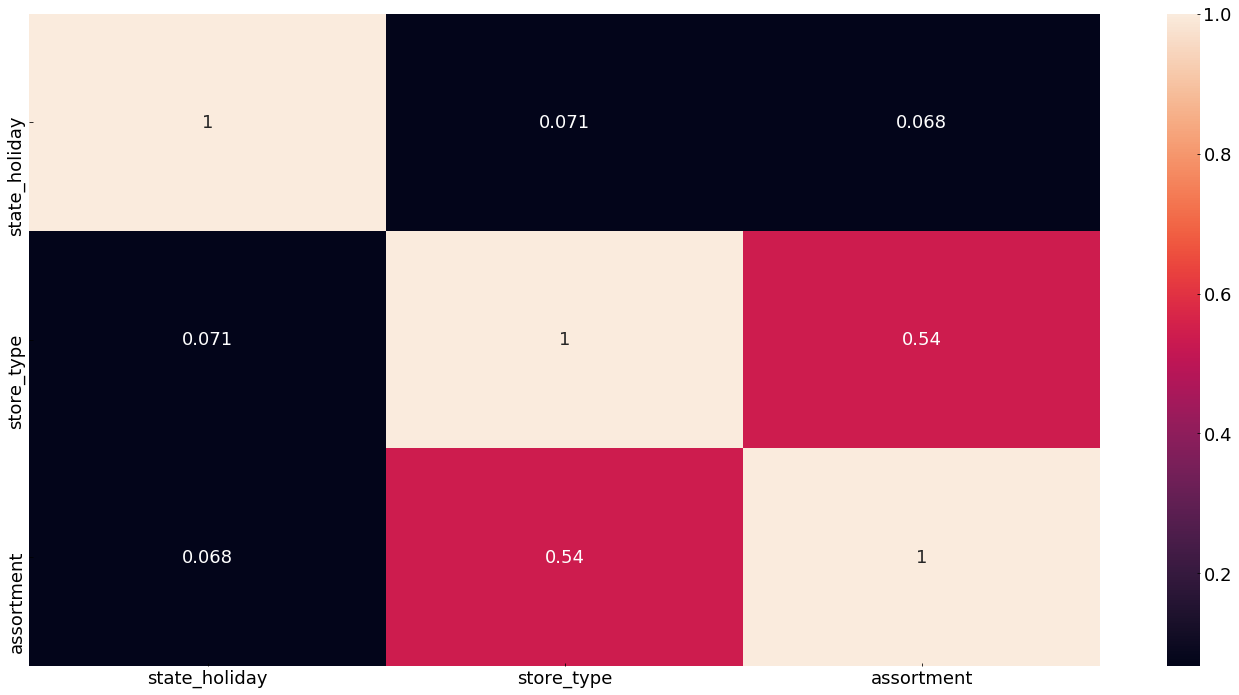

In [68]:
sns.heatmap(d, annot=True);

## 6.0 Data Preparation

In [69]:
df5 = df4.copy()

### 6.1 Normalização

In [70]:
# Primeira: Encontrar as variáveis que precisam ser normlizadas, vendo as distribuições delas (lá na Análise Univariada)
# Nenhuma das varíaveis tem distribuição normal, então nenhuma será normalizada.
# Serão então passadas pelo Rescaling

### 6.2 Rescaling

In [71]:
a = df5.select_dtypes(include=['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


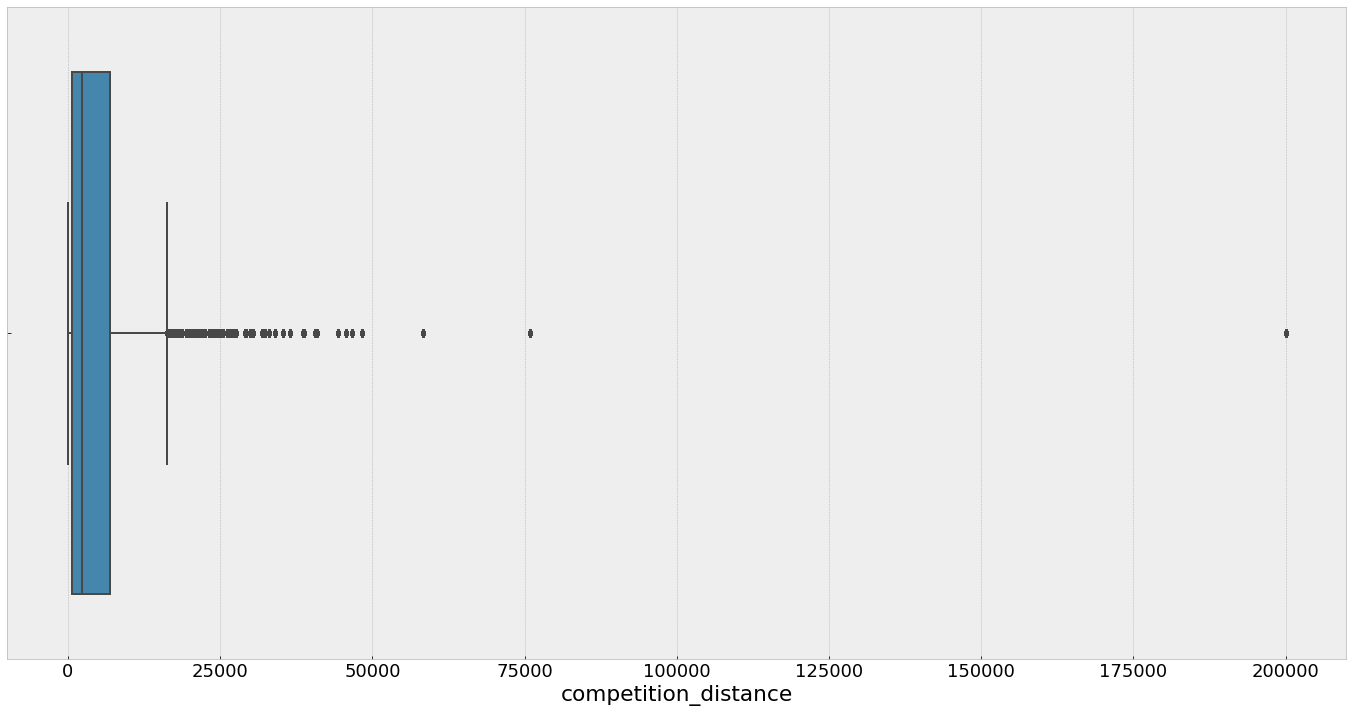

In [72]:
sns.boxplot(df5['competition_distance'])

In [73]:
rs = RobustScaler ()
mms= MinMaxScaler ()

# competition_distance (outliers são bem expressivos - usar o robustscaler)
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']]. values)

# ompetition_time_month (outliers são bem expressivos - usar o robustscaler)
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']]. values)

# promo_time_week (outliers não são muito expressivos então irei usar o MinMaxScaler)
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']]. values)

# year
df5['year'] = mms.fit_transform(df5[['year']]. values)

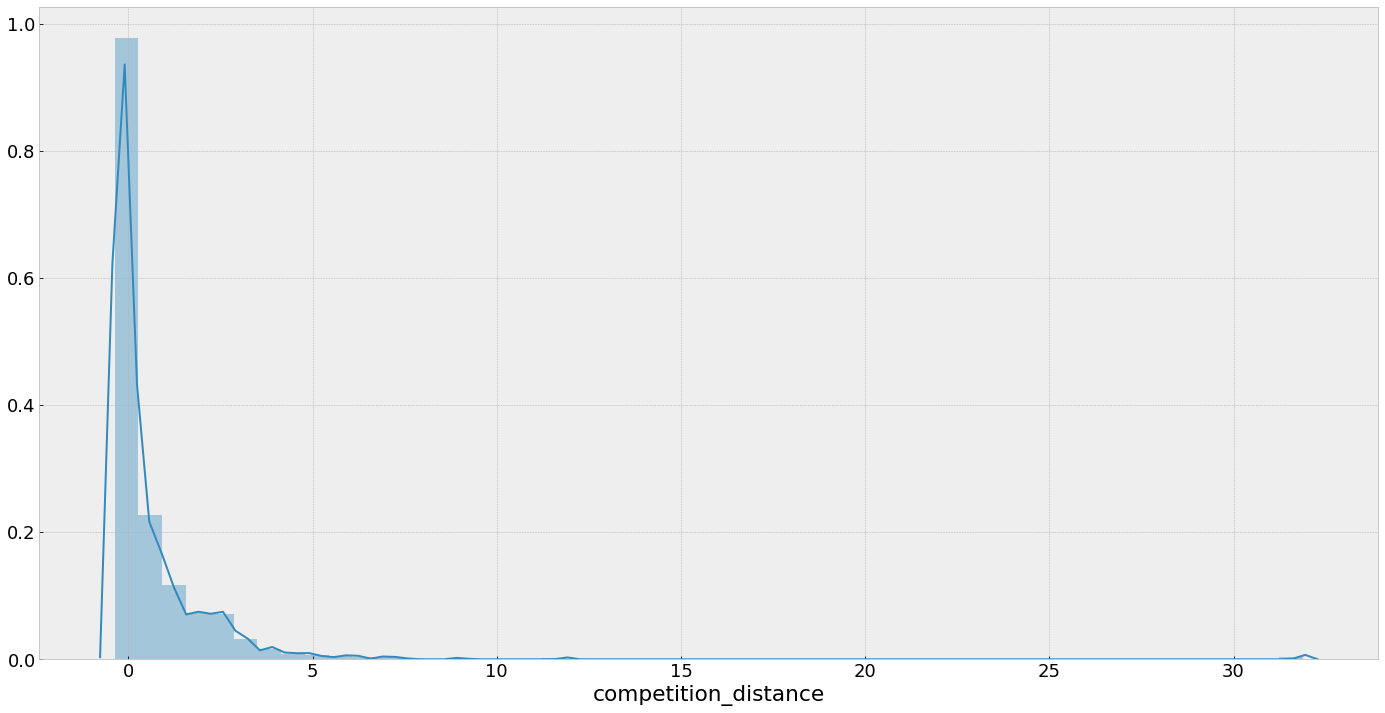

In [74]:
sns.distplot(df5['competition_distance'])

### 6.3 Transformação

#### 6.3.1 Encoding

In [75]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns = ['state_holiday'])

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - Ordinal Encoding
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


In [76]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


#### 6.3.2 Response Variable Transformation

In [77]:
df5['sales'] = np.log1p(df5['sales'])

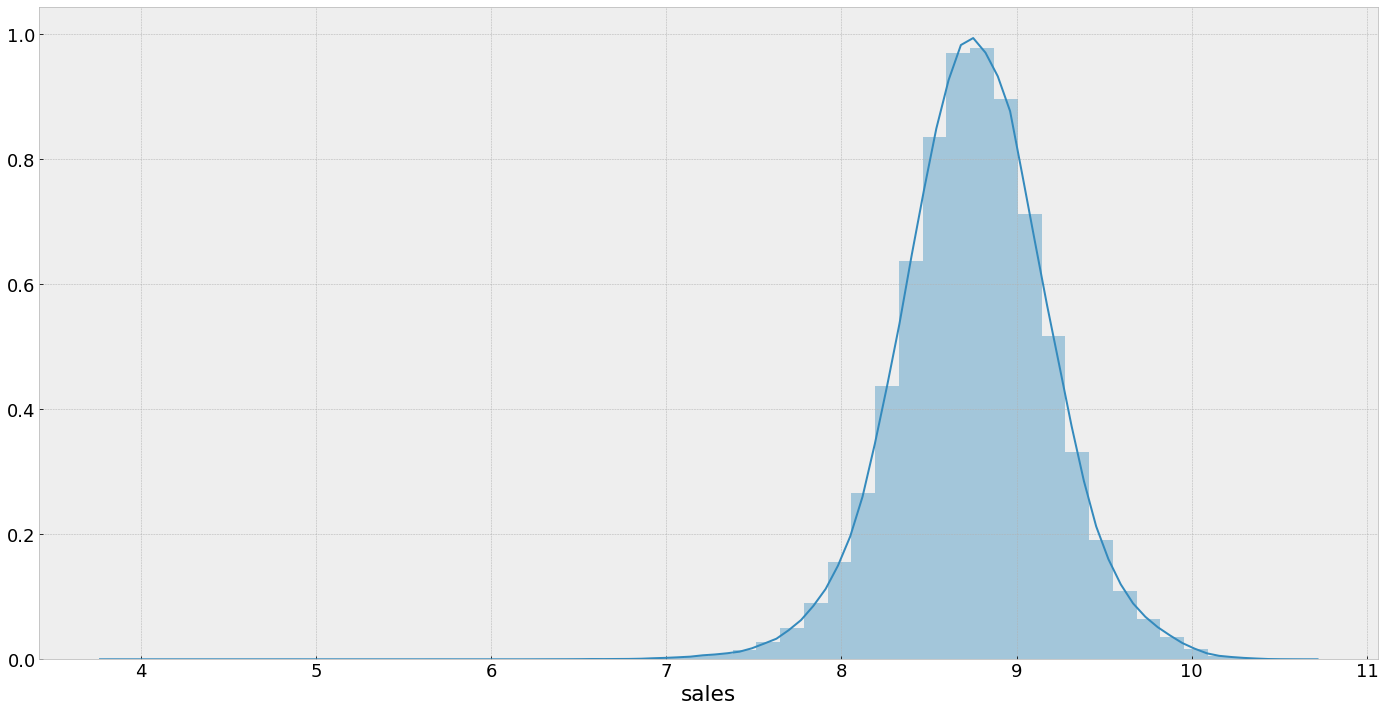

In [78]:
sns.distplot(df5['sales'])

#### 6.3.3 Nature Transformation

In [79]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin ( x*( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos ( x*( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin ( x*( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos ( x*( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin ( x*( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos ( x*( 2. * np.pi/30 ) ) )


# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin ( x*( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos ( x*( 2. * np.pi/52 ) ) )


In [80]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 7.0 Feature Selection

In [81]:
df6 = df5.copy()

### 7.1 Split Dataframe into Training and Dataset

In [82]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [83]:
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [84]:
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [85]:
# Encontrar a data das últimas 6 semanas para separar os dados para o conjunto de teste

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

# A primeira data até o dia 18/06/2015 serão os dados de treino, e as datas do dia 19/06/2015 para frente serão os dados de teste

Timestamp('2015-06-19 00:00:00')

In [86]:
# Training Dataset

X_train = df6[df6['date']  < '2015-06-19']
y_train = X_train['sales']


# Test Dataset

X_test = df6[df6['date']  >= '2015-06-19']
y_test = X_train['sales']


print('Training Min Date: {}'.format (X_train['date'].min()))
print('Training Max Date: {}'.format (X_train['date'].max()))

print('\nTest Min Date: {}'.format (X_test['date'].min()))
print('Test Max Date: {}'.format (X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


### 7.2 Boruta as Feature Selector

In [87]:
# Training and test Dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
y_train_n = y_train.values.ravel()

# Define RandomForestRegressor
rf = RandomForestRegressor (n_jobs=-1)

# Define Boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


#### 7.2.1 Best Features from Boruta

In [88]:
# colunas com maior range
cols_selected = boruta.support_.tolist()

# criar variavel X_train_fs sem a coluna date e sales best features
X_train_fs = X_train.drop(['date', 'sales'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = list (np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [90]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

### 7.3 Manual Features Selection

In [92]:
cols_selected_boruta = ['store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'day_of_week_sin',
                         'day_of_week_cos',
                         'month_sin',
                         'month_cos',
                         'day_sin',
                         'day_cos',
                         'week_of_year_sin',
                         'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta.extend(feat_to_add)

In [93]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']